# Importação das bibliotecas utilizadas na Analise

In [16]:
import pandas as pd
import numpy as np
import warnings

# Funções auxiliares
from utils.A_utils import dist_cumulativa, plot_boxplot
from utils.A_utils import teste_shapiro, teste_levene, teste_mannwhitneyu
from utils.A_utils import avaliacao_teste_shapiro, agrupar, remocao_todos_outliers

warnings.filterwarnings('ignore')

# Conjunto de dados fornecidos pela empresa ACME

Importação dos dados para analise

<img src="https://www.beaconjournal.com/gcdn/presto/2022/02/17/NABJ/9f2016aa-be3c-4dbb-a1cb-0de34fb5a69e-Coyote_Acme_Warner_Bros..jpg?width=660&height=330&fit=crop&format=pjpg&auto=webp">

In [17]:
( 
    axadefeito,acme,
    participacao,
    desenvolvedores
) = pd.read_excel('../ACME_dataset_1.xlsx',sheet_name=None).values()

# Pré-processamento dos dados

## Agrupando os dados de projetos que utilizaram a técnica ad-hoc e a técnica axadefeito no mesmo dataframe

In [18]:
projetos = pd.concat([acme,axadefeito]).sort_values(by='Projeto').reset_index(drop=True).drop(columns='SUCESSO')
projetos.head()

,Projeto,Porte,Técnica,Tempo Inspeçao (horas),Defeitos,Esforço (h/h),Tamanho (Kloc),Produtividade (kloc/mês)
0,1,Pequeno,ACME,0.0,0,5.25,7,5.333333
1,2,Pequeno,ACME,0.0,0,7.50,10,5.333333
2,3,Pequeno,AXADEFEITO,0.0,0,7.50,10,5.333333
3,4,Pequeno,AXADEFEITO,0.0,0,8.00,7,3.500000
4,5,Médio,ACME,4.0,0,39.25,51,5.197452


## Extraindo apenas projetos que realizaram Inspeção

In [19]:
projetos_utilizaveis = projetos.loc[projetos['Tempo Inspeçao (horas)'] > 0].copy()

Como não tem como associar a participação dos desenvolvedores nos projetos que estão usado a técnica axadefeito, então não seria possivel comparar grupos de devs similares usando técnicas distintas 

## Criação da coluna '#Defeitos/TempoInspecao' e separação das colunas de interesse

In [20]:
projetos_utilizaveis.loc[:,'#Defeitos/TempoInspecao'] = projetos_utilizaveis['Defeitos'].div(
    projetos_utilizaveis['Tempo Inspeçao (horas)'])

colunas_de_interesse = [
    'Tempo Inspeçao (horas)', 'Defeitos',
    '#Defeitos/TempoInspecao'
]

# Análise descritiva em função do porte e das técnicas

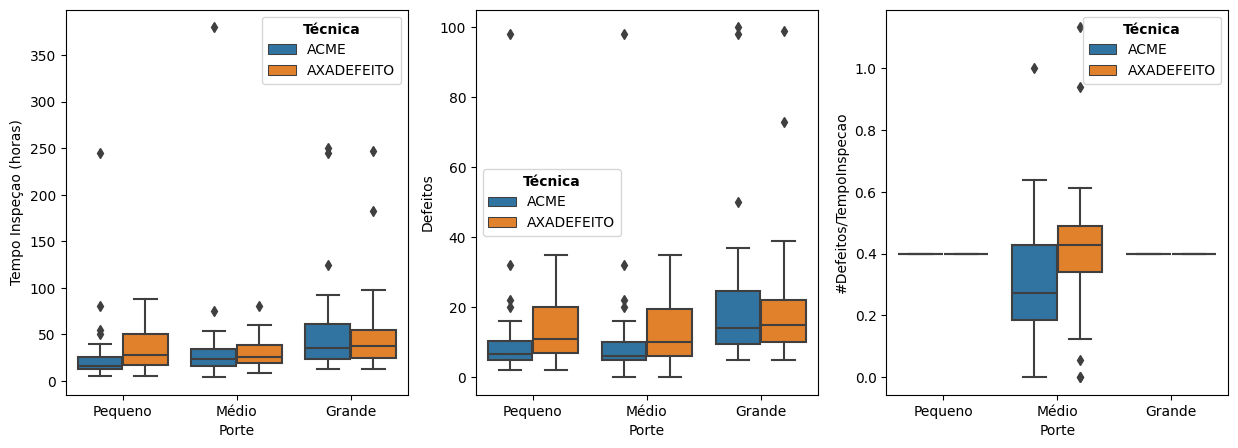

In [21]:
plot_boxplot(projetos_utilizaveis,colunas_de_interesse)

Na coluna '#Defeitos/TempoInspecao' temos que projetos de Pequeno e Grande porte obtiveram desempenho iguais ao alternar apenas a técnica de inspeção. Contudo, em projetos de médio porte há índicios de que a técnica Axadefeito tenha desempenhado melhor papel na detecção de defeitos do que com inspeção ad-hoc da empresa ACME

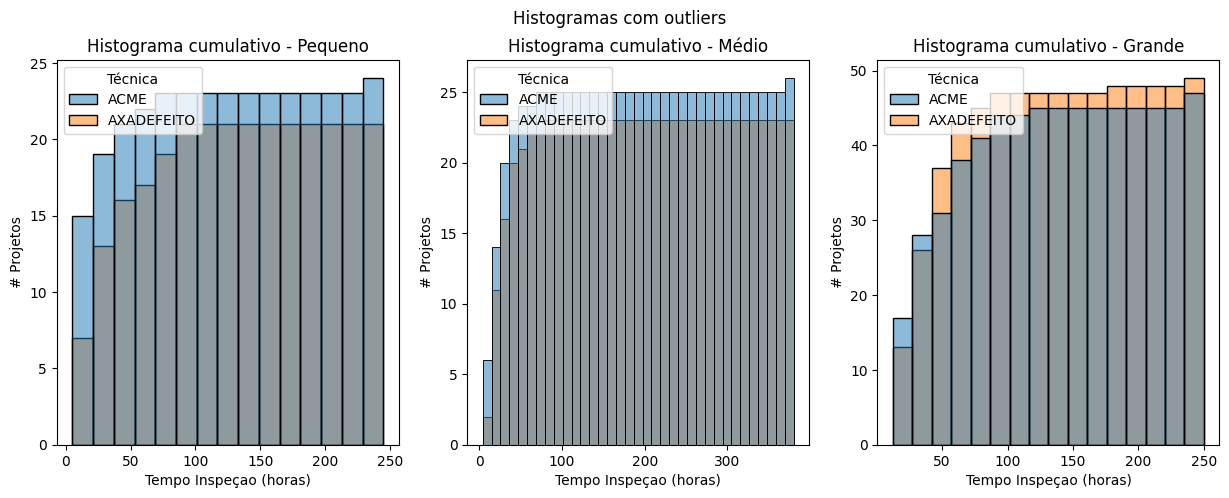

In [22]:
dist_cumulativa(projetos_utilizaveis)

O histograma cumulativo indica que, embora ambas as técnicas apresentem desempenhos semelhantes, o tempo de inspeção em projetos de pequeno e médio porte é reduzido ao usar a técnica Axadefeito.

# Testes de Hipotéses

## Identificação do tamanho das amostras

In [23]:
porte_tecnica_group = projetos_utilizaveis.groupby(by=['Porte','Técnica'])

In [24]:
porte_tecnica_group['Projeto'].count().to_frame()

Projeto
Porte   Técnica            
Grande  ACME             47
        AXADEFEITO       49
Médio   ACME             26
        AXADEFEITO       23
Pequeno ACME             24
        AXADEFEITO       21

## Teste de Shapiro-Wilk para identificar se as amostras possuem distribuição normal
Utilizaremos o teste de Shapiro-Wilk para verificar se uma amostra de dados segue uma distribuição normal

In [25]:
idx_list, dict_tests = teste_shapiro(porte_tecnica_group,colunas_de_interesse)

### Utilização de alfa = 0.05 para determinar se será possivel rejeitar a hipotése nula do teste de shapiro-wilk

O teste de Shapiro-Wilk formula a hipótese nula (H0) de que os dados são provenientes de uma população normalmente distribuída. Um valor de alfa baixo (geralmente menor que 0,05) indica que você deve rejeitar a hipótese nula, sugerindo que os dados não seguem uma distribuição normal. Por outro lado, um valor de alfa elevado sugere que os dados podem ser considerados como provenientes de uma distribuição normal.

In [26]:
results = avaliacao_teste_shapiro(idx_list,dict_tests,alfa=0.05)
results

Tempo Inspeçao (horas)-Shapiro  \
Grande  ACME         (0.6524451971054077, 2.7145226066949135e-09)   
        AXADEFEITO    (0.660088300704956, 2.1773671754488078e-09)   
Médio   ACME        (0.38274580240249634, 2.0139641065952674e-09)   
        AXADEFEITO      (0.8943251967430115, 0.01934642158448696)   
Pequeno ACME         (0.48917537927627563, 4.433870515185845e-08)   
        AXADEFEITO      (0.8885175585746765, 0.02108931913971901)   

                                                 Defeitos-Shapiro  \
Grande  ACME         (0.6524451971054077, 2.7145226066949135e-09)   
        AXADEFEITO    (0.660088300704956, 2.1773671754488078e-09)   
Médio   ACME        (0.49988752603530884, 2.4935355114052982e-08)   
        AXADEFEITO      (0.9019625186920166, 0.02775290608406067)   
Pequeno ACME         (0.48917537927627563, 4.433870515185845e-08)   
        AXADEFEITO      (0.8885175585746765, 0.02108931913971901)   

                              #Defeitos/TempoInspecao-Shapiro  \
Grande  ACME                                       (1.0, 1.0)   
        AXADEFEITO                                 (1.0, 1.0)   
Médio   ACME        (0.9260732531547546, 0.06251519173383713)   
        AXADEFEITO  (0.892756998538971, 0.017979398369789124)   
Pequeno ACME                                       (1.0, 1.0)   
        AXADEFEITO                                 (1.0, 1.0)   

                   Tempo Inspeçao (horas)-ShapiroResultado  \
Grande  ACME                                  H0 rejeitada   
        AXADEFEITO                            H0 rejeitada   
Médio   ACME                                  H0 rejeitada   
        AXADEFEITO                            H0 rejeitada   
Pequeno ACME                                  H0 rejeitada   
        AXADEFEITO                            H0 rejeitada   

                   Defeitos-ShapiroResultado  \
Grande  ACME                    H0 rejeitada   
        AXADEFEITO              H0 rejeitada   
Médio   ACME                    H0 rejeitada   
        AXADEFEITO              H0 rejeitada   
Pequeno ACME                    H0 rejeitada   
        AXADEFEITO              H0 rejeitada   

                   #Defeitos/TempoInspecao-ShapiroResultado  
Grande  ACME                      H0 não pode ser rejeitada  
        AXADEFEITO                H0 não pode ser rejeitada  
Médio   ACME                      H0 não pode ser rejeitada  
        AXADEFEITO                             H0 rejeitada  
Pequeno ACME                      H0 não pode ser rejeitada  
        AXADEFEITO                H0 não pode ser rejeitada

In [27]:
results[['#Defeitos/TempoInspecao-ShapiroResultado',
 'Defeitos-ShapiroResultado',
 'Tempo Inspeçao (horas)-ShapiroResultado']]

#Defeitos/TempoInspecao-ShapiroResultado  \
Grande  ACME                      H0 não pode ser rejeitada   
        AXADEFEITO                H0 não pode ser rejeitada   
Médio   ACME                      H0 não pode ser rejeitada   
        AXADEFEITO                             H0 rejeitada   
Pequeno ACME                      H0 não pode ser rejeitada   
        AXADEFEITO                H0 não pode ser rejeitada   

                   Defeitos-ShapiroResultado  \
Grande  ACME                    H0 rejeitada   
        AXADEFEITO              H0 rejeitada   
Médio   ACME                    H0 rejeitada   
        AXADEFEITO              H0 rejeitada   
Pequeno ACME                    H0 rejeitada   
        AXADEFEITO              H0 rejeitada   

                   Tempo Inspeçao (horas)-ShapiroResultado  
Grande  ACME                                  H0 rejeitada  
        AXADEFEITO                            H0 rejeitada  
Médio   ACME                                  H0 rejeitada  
        AXADEFEITO                            H0 rejeitada  
Pequeno ACME                                  H0 rejeitada  
        AXADEFEITO                            H0 rejeitada

Temos então as colunas 'Defeitos' e 'Tempo Inspeção (horas)' em todos os agrupamentos feitos possuem distribuição normal. E na coluna '#Defeitos/TempoInsepeção' apenas a amostra que apresenta dados de projetos de porte Médio com a técnica Axadefeito possui distribuição normal

### Utilização do teste de levene para identificar a homocedasticidade dos dados de tempo de Inspeção

#### Foram realizado 2 testes, um teste para identificar homocedasticidade entre amostras que possuem o mesmo porte e outro teste para identificar homocedasticidade entre amostras que possuem mesma técnica

O teste formula a seguinte hipótese:

Hipótese nula (H0): As variâncias dos grupos são iguais.

Hipótese alternativa (H1): Pelo menos uma das variâncias dos grupos é diferente das outras.

Se o resultado do teste de Levene for significativo (geralmente se o valor p for menor que 0,05, mas isso pode depender do nível de significância escolhido), você rejeita a hipótese nula e conclui que há evidências de que as variâncias dos grupos não são iguais.

Ao encontrar heterocedasticidade (variâncias desiguais entre os grupos), pode ser necessário realizar transformações nos dados ou recorrer a técnicas estatísticas robustas que não assumem homogeneidade de variâncias.

In [28]:
# Não consigo rejeitar a hipotese nula de que a variancia populacionais são iguais das amostras 
# de uma mesma técnica e portes distintos e de um mesmo porte e técnicas distintas
teste_levene(projetos_utilizaveis)

{'ACME': LeveneResult(statistic=0.1598406430857783, pvalue=0.8525107503294878),
 'AXADEFEITO': LeveneResult(statistic=1.1698168439269472, pvalue=0.31509846911496975),
 'Grande': LeveneResult(statistic=0.42505093706928343, pvalue=0.5160184105552446),
 'Médio': LeveneResult(statistic=0.7759874568209109, pvalue=0.38285370280367303),
 'Pequeno': LeveneResult(statistic=0.003000457046364036, pvalue=0.9565702982310833)}

Em nenhum dos agrupamentos foi possivel rejeitar a hipotese nula do teste de levene, então para realizar os testes de hipotese desse estudo precisaremos recorrer a metódos não-paramétricos

### Teste de Mann-Whitney U

In [29]:
teste_mannwhitneyu(porte_tecnica_group,colunas_de_interesse)

,Tempo Inspeçao (horas),Defeitos,#Defeitos/TempoInspecao
Grande,"(1131.5, 0.8862362086249319)","(1131.5, 0.8862362086249319)","(1151.5, 1.0)"
Médio,"(268.0, 0.5408252698113492)","(220.5, 0.11714995579089353)","(216.5, 0.10021982428903646)"
Pequeno,"(170.5, 0.06450566991909974)","(170.5, 0.06450566991909974)","(252.0, 1.0)"


Ao utilizar o teste de Mann-Whitney para testar amostras de mesmo porte e técnicas de diferente, nas colunas de interesse ('Tempo Inspeçao (horas)', 'Defeitos' e '#Defeitos/TempoInspecao') para o valor de alfa = 0.05, não seria possivel rejeitar a hipotése nula do teste de Mann-Whitney, assim não seria possivel afirmar que uma técnica é mais eficiente que outra. Contudo, para alfa = 0.10, seria possivel concluir que o a média de tempo de inspeção e a média da quantidade de defeitos encontrados por projeto de pequeno é distinta, contudo não como avaliar diferença de eficiência entre as técnicas em projetos de pequeno porte 

# Remoção dos outliers

In [30]:
df_so_dti = pd.concat([remocao_todos_outliers(j,'#Defeitos/TempoInspecao') for i,j in porte_tecnica_group])
df_so_ti = pd.concat([remocao_todos_outliers(j,'Tempo Inspeçao (horas)') for i,j in porte_tecnica_group])

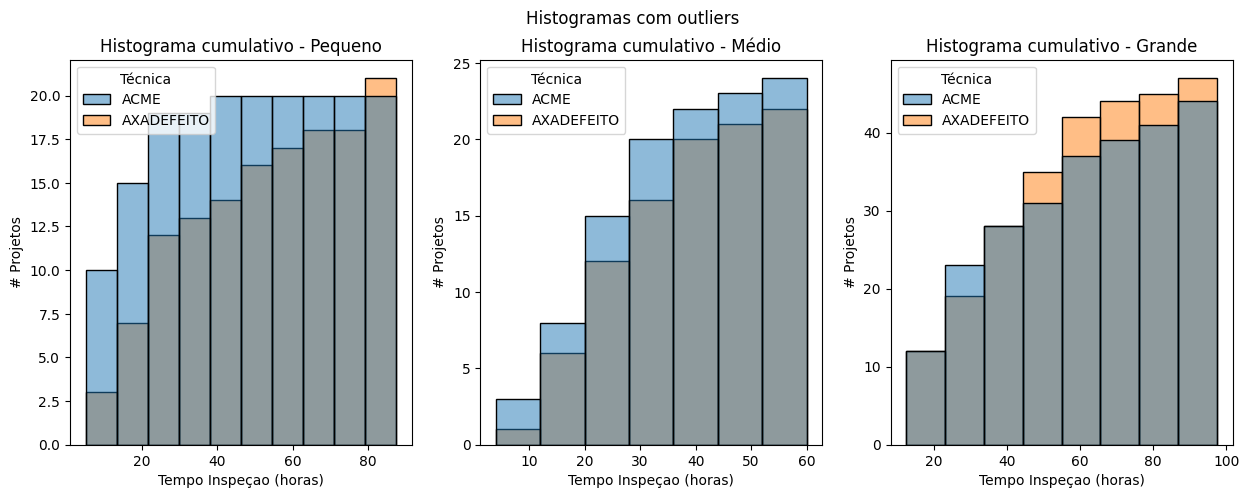

In [31]:
dist_cumulativa(df_so_ti)

In [32]:
df_so_dti.groupby(by=['Porte','Técnica'])['Projeto'].count().to_frame()

Projeto
Porte   Técnica            
Grande  ACME             47
        AXADEFEITO       49
Médio   ACME             25
        AXADEFEITO       18
Pequeno ACME             24
        AXADEFEITO       21

In [33]:
df_so_ti.groupby(by=['Porte','Técnica'])['Projeto'].count().to_frame()

Projeto
Porte   Técnica            
Grande  ACME             44
        AXADEFEITO       47
Médio   ACME             24
        AXADEFEITO       22
Pequeno ACME             20
        AXADEFEITO       21

In [34]:
porte_tecnica_group_so_dti = df_so_dti.groupby(by=['Porte','Técnica'])
porte_tecnica_group_so_ti = df_so_ti.groupby(by=['Porte','Técnica'])

In [35]:
idx_list_dti, dict_tests_dti = teste_shapiro(porte_tecnica_group_so_dti,colunas_de_interesse)
idx_list_ti, dict_tests_ti = teste_shapiro(porte_tecnica_group_so_ti,colunas_de_interesse)

In [36]:
avaliacao_teste_shapiro(idx_list_dti,dict_tests_dti,alfa=0.05)

Tempo Inspeçao (horas)-Shapiro  \
Grande  ACME        (0.6524451971054077, 2.7145226066949135e-09)   
        AXADEFEITO   (0.660088300704956, 2.1773671754488078e-09)   
Médio   ACME        (0.3897770047187805, 3.5934659692316018e-09)   
        AXADEFEITO    (0.8613283038139343, 0.012844356708228588)   
Pequeno ACME        (0.48917537927627563, 4.433870515185845e-08)   
        AXADEFEITO     (0.8885175585746765, 0.02108931913971901)   

                                                 Defeitos-Shapiro  \
Grande  ACME         (0.6524451971054077, 2.7145226066949135e-09)   
        AXADEFEITO    (0.660088300704956, 2.1773671754488078e-09)   
Médio   ACME        (0.47317975759506226, 2.0549297374827802e-08)   
        AXADEFEITO     (0.8904672861099243, 0.039311230182647705)   
Pequeno ACME         (0.48917537927627563, 4.433870515185845e-08)   
        AXADEFEITO      (0.8885175585746765, 0.02108931913971901)   

                             #Defeitos/TempoInspecao-Shapiro  \
Grande  ACME                                      (1.0, 1.0)   
        AXADEFEITO                                (1.0, 1.0)   
Médio   ACME        (0.9806638360023499, 0.8979429006576538)   
        AXADEFEITO  (0.9235175848007202, 0.1492086797952652)   
Pequeno ACME                                      (1.0, 1.0)   
        AXADEFEITO                                (1.0, 1.0)   

                   Tempo Inspeçao (horas)-ShapiroResultado  \
Grande  ACME                                  H0 rejeitada   
        AXADEFEITO                            H0 rejeitada   
Médio   ACME                                  H0 rejeitada   
        AXADEFEITO                            H0 rejeitada   
Pequeno ACME                                  H0 rejeitada   
        AXADEFEITO                            H0 rejeitada   

                   Defeitos-ShapiroResultado  \
Grande  ACME                    H0 rejeitada   
        AXADEFEITO              H0 rejeitada   
Médio   ACME                    H0 rejeitada   
        AXADEFEITO              H0 rejeitada   
Pequeno ACME                    H0 rejeitada   
        AXADEFEITO              H0 rejeitada   

                   #Defeitos/TempoInspecao-ShapiroResultado  
Grande  ACME                      H0 não pode ser rejeitada  
        AXADEFEITO                H0 não pode ser rejeitada  
Médio   ACME                      H0 não pode ser rejeitada  
        AXADEFEITO                H0 não pode ser rejeitada  
Pequeno ACME                      H0 não pode ser rejeitada  
        AXADEFEITO                H0 não pode ser rejeitada

In [37]:
avaliacao_teste_shapiro(idx_list_ti,dict_tests_ti,alfa=0.05)

Tempo Inspeçao (horas)-Shapiro  \
Grande  ACME        (0.8856297731399536, 0.00040518378955312073)   
        AXADEFEITO    (0.9379268288612366, 0.014882960356771946)   
Médio   ACME            (0.9717548489570618, 0.7103837132453918)   
        AXADEFEITO      (0.9514228701591492, 0.3369480073451996)   
Pequeno ACME           (0.9132116436958313, 0.07340069115161896)   
        AXADEFEITO     (0.8885175585746765, 0.02108931913971901)   

                                                Defeitos-Shapiro  \
Grande  ACME        (0.8856297731399536, 0.00040518378955312073)   
        AXADEFEITO    (0.9379268288612366, 0.014882960356771946)   
Médio   ACME          (0.8784918785095215, 0.007750254590064287)   
        AXADEFEITO    (0.9113417267799377, 0.050425175577402115)   
Pequeno ACME           (0.9132116436958313, 0.07340069115161896)   
        AXADEFEITO     (0.8885175585746765, 0.02108931913971901)   

                               #Defeitos/TempoInspecao-Shapiro  \
Grande  ACME                                        (1.0, 1.0)   
        AXADEFEITO                                  (1.0, 1.0)   
Médio   ACME         (0.9257597923278809, 0.07839958369731903)   
        AXADEFEITO  (0.9001866579055786, 0.029982300475239754)   
Pequeno ACME                                        (1.0, 1.0)   
        AXADEFEITO                                  (1.0, 1.0)   

                   Tempo Inspeçao (horas)-ShapiroResultado  \
Grande  ACME                                  H0 rejeitada   
        AXADEFEITO                            H0 rejeitada   
Médio   ACME                     H0 não pode ser rejeitada   
        AXADEFEITO               H0 não pode ser rejeitada   
Pequeno ACME                     H0 não pode ser rejeitada   
        AXADEFEITO                            H0 rejeitada   

                    Defeitos-ShapiroResultado  \
Grande  ACME                     H0 rejeitada   
        AXADEFEITO               H0 rejeitada   
Médio   ACME                     H0 rejeitada   
        AXADEFEITO  H0 não pode ser rejeitada   
Pequeno ACME        H0 não pode ser rejeitada   
        AXADEFEITO               H0 rejeitada   

                   #Defeitos/TempoInspecao-ShapiroResultado  
Grande  ACME                      H0 não pode ser rejeitada  
        AXADEFEITO                H0 não pode ser rejeitada  
Médio   ACME                      H0 não pode ser rejeitada  
        AXADEFEITO                             H0 rejeitada  
Pequeno ACME                      H0 não pode ser rejeitada  
        AXADEFEITO                H0 não pode ser rejeitada

In [38]:
teste_levene(df_so_dti)

{'ACME': LeveneResult(statistic=0.15707037856770403, pvalue=0.854870149286194),
 'AXADEFEITO': LeveneResult(statistic=0.7757275327469797, pvalue=0.4636000472187636),
 'Grande': LeveneResult(statistic=0.42505093706928343, pvalue=0.5160184105552446),
 'Médio': LeveneResult(statistic=0.5845306750091859, pvalue=0.4489200921050053),
 'Pequeno': LeveneResult(statistic=0.003000457046364036, pvalue=0.9565702982310833)}

In [39]:
teste_levene(df_so_ti)

{'ACME': LeveneResult(statistic=7.231611499696145, pvalue=0.001257902279199466),
 'AXADEFEITO': LeveneResult(statistic=3.010319974741589, pvalue=0.054436091986716825),
 'Grande': LeveneResult(statistic=0.39058826550763565, pvalue=0.5335894331631206),
 'Médio': LeveneResult(statistic=0.01509376322597679, pvalue=0.9027800554873622),
 'Pequeno': LeveneResult(statistic=9.97373606517994, pvalue=0.0030618950185192914)}

Olhando os dados de Tempo de Inspeção, temos que as amostras de projetos de pequeno porte tem homocedasticidade, contudo projetos de pequeno porte que usam a técnica ACME não apresentam uma distribuição normal. E apesar dos projetos que usam a Técnica da ACME apresentam homocedasticidade, projetos de pequeno e é médio porte que usam a técnica da ACME não apresentam distribuição normal. Com isso, usaremos apenas testes de hipotése não parametricos 

In [40]:
teste_mannwhitneyu(porte_tecnica_group_so_dti,colunas_de_interesse)

,Tempo Inspeçao (horas),Defeitos,#Defeitos/TempoInspecao
Grande,"(1131.5, 0.8862362086249319)","(1131.5, 0.8862362086249319)","(1151.5, 1.0)"
Médio,"(197.0, 0.4979980256337464)","(130.0, 0.019562203780744775)","(123.5, 0.012848128493903628)"
Pequeno,"(170.5, 0.06450566991909974)","(170.5, 0.06450566991909974)","(252.0, 1.0)"


Ao remover outliers presentes na coluna '#Defeitos/TempoInspecao', temos que em projetos de Médio porte há evidência que é possivel rejeitar a hipotése nula de que a média da eficiência de ambas as técnicas de inspeção são iguais

In [41]:
teste_mannwhitneyu(porte_tecnica_group_so_ti,colunas_de_interesse)

,Tempo Inspeçao (horas),Defeitos,#Defeitos/TempoInspecao
Grande,"(987.5, 0.714536105014925)","(987.5, 0.714536105014925)","(1034.0, 1.0)"
Médio,"(223.0, 0.37263058123841597)","(177.0, 0.05634967397818717)","(194.5, 0.1289290535989367)"
Pequeno,"(99.5, 0.003966149721504965)","(99.5, 0.003966149721504965)","(210.0, 1.0)"


Ao remover outlier presentes na coluna 'Tempo Inspecao (horas)', temos que em projetos de pequeno porte há evidência que é possivel rejeitar a hipotése nula de que a média de tempo gasto com inspeção de ambas as técnicas de inspeção são iguais

<img src="https://static.wikia.nocookie.net/looneytunes/images/2/22/WileThatsAllFolks.png/revision/latest?cb=20180510012629">